Skipping, found downloaded files in "./sign-language-mnist" (use force=True to force download)


Epoch 1/50
151/151 [==============================] - 10s 53ms/step - loss: 3.1033 - accuracy: 0.1940 - val_loss: 4.0439 - val_accuracy: 0.0444 - lr: 0.0010
Epoch 2/50
151/151 [==============================] - 7s 44ms/step - loss: 1.9541 - accuracy: 0.4040 - val_loss: 5.8466 - val_accuracy: 0.0829 - lr: 0.0010
Epoch 3/50
151/151 [==============================] - 8s 52ms/step - loss: 1.4095 - accuracy: 0.5438 - val_loss: 8.9542 - val_accuracy: 0.0652 - lr: 0.0010
Epoch 4/50
151/151 [==============================] - 7s 49ms/step - loss: 1.1294 - accuracy: 0.6254 - val_loss: 0.7658 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 5/50
151/151 [==============================] - 7s 44ms/step - loss: 0.9440 - accuracy: 0.6848 - val_loss: 0.3848 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 6/50
151/151 [==============================] - 7s 45ms/step - loss: 0.8258 - accuracy: 0.7253 - val_loss: 0.2552 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 7/50
151/151 [==============================] - 8s 53ms/s

ValueError: Input 0 of layer "conv2d_7" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 24)

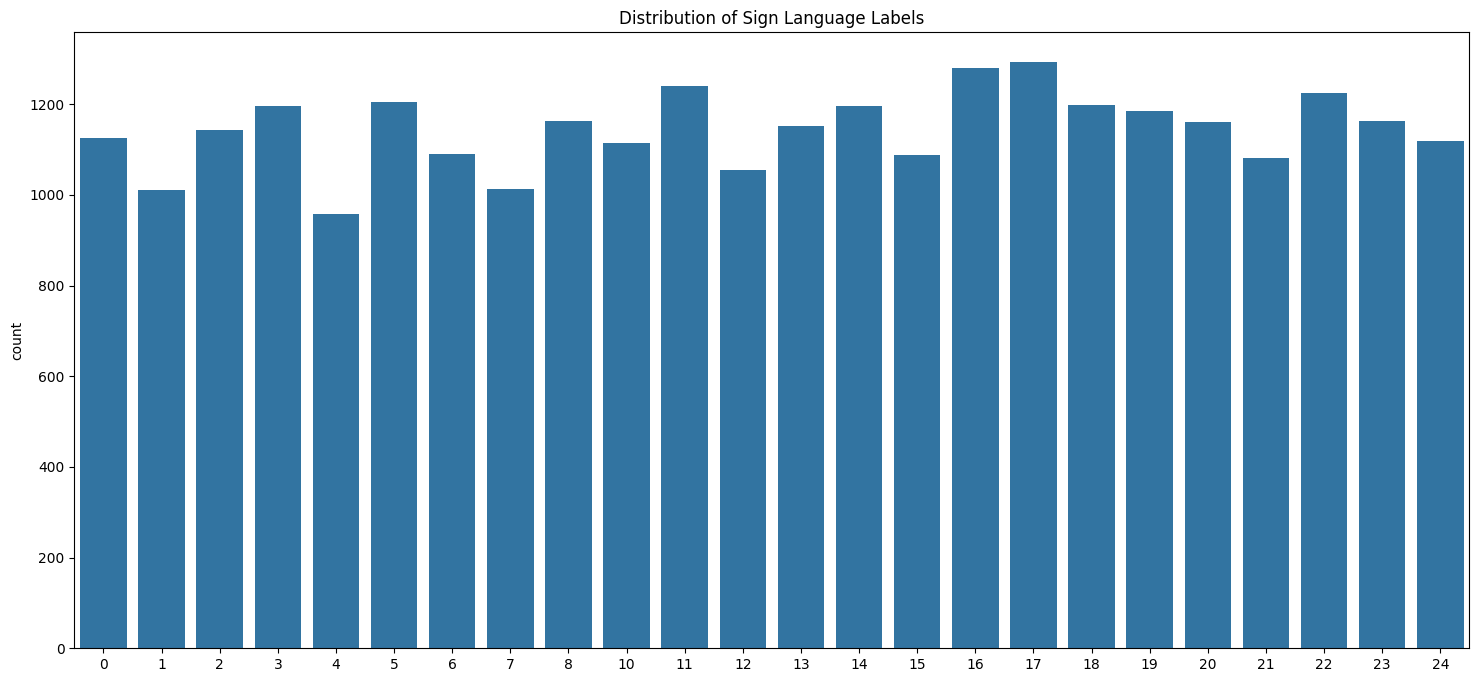

In [4]:
# Import necessary libraries
!pip install opendatasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras
from keras.applications import VGG16, ResNet50, InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import opendatasets as od
import tensorflow as tf
# Function to select the default device (GPU if available, else CPU)
def get_default_device():
    if tf.config.list_physical_devices('GPU'):
        return tf.device("GPU")
    else:
        return tf.device("CPU")

# Function to move data to the selected device
def to_device(data, device):
    with tf.device(device.name):
        return data
# Call the function to get the default device
my_device = get_default_device()

# Download the dataset using opendatasets
od.download('https://www.kaggle.com/datamunge/sign-language-mnist')

# Load the dataset
train = pd.read_csv('./sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('./sign-language-mnist/sign_mnist_test.csv')

# Explore the dataset
labels = train['label'].values
unique_labels = np.unique(labels)

# Data exploration
plt.figure(figsize=(18, 8))
sns.countplot(x=labels)
plt.title("Distribution of Sign Language Labels")

# Drop the label column from the training set
train.drop('label', axis=1, inplace=True)

# Reshape the images into a format suitable for the model
images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

# Encode labels using LabelBinarizer to convert them into a suitable format
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

# Split the dataset into train (70%) and test (30%)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=101)

# Normalize the pixel values between 0 and 1 for better model training
x_train = x_train / 255
x_test = x_test / 255

# Reshape images to match the input shape expected by the models
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Data Augmentation: Augment the training data to create new training samples
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning Rate Schedulers: Implement learning rate schedulers
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Define constants for the models
batch_size = 128  # Define batch size here
num_classes = 24
epochs = 50

# Apply Data Augmentation to the training data
augmented_data = datagen.flow(x_train, y_train, batch_size=batch_size)

# Re-build and compile the custom CNN model with Batch Normalization
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

# Train the model with Data Augmentation and Learning Rate Schedulers
history = model.fit(augmented_data, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size,
                    callbacks=[reduce_lr, early_stopping])
# Batch Normalization: Add BatchNormalization layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Different CNN Architectures: Experiment with VGG16, ResNet50, and InceptionV3
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_model = to_device(vgg16_model, my_device)
#vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Build and train the ResNet50 model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model = to_device(resnet50_model, my_device)
#resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inceptionv3_model = to_device(inceptionv3_model, my_device)
# Dropout Rate Tuning: Fine-tune the dropout rate
model.add(Dropout(0.3))

# Regularization: Add L2 regularization
from keras.regularizers import l2
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Data Balancing: If needed, apply data balancing techniques
# Oversampling, Undersampling, or Class Weighting

# Continue with model compilation, training, and evaluation...
# Re-compile the model after adding Batch Normalization, Dropout Rate Tuning, Regularization, etc.
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

# Train the model
history = model.fit(augmented_data, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size,
                    callbacks=[reduce_lr, early_stopping])

# Evaluate the model on the test data
test_labels = test['label']
test.drop('label', axis=1, inplace=True)
test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_labels = label_binrizer.fit_transform(test_labels)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Predict using the model
y_pred = model.predict(test_images)

# Calculate accuracy for the model
accuracy = accuracy_score(test_labels, y_pred.round())
print("Model Test Accuracy:", accuracy)

# Calculate other evaluation metrics (confusion matrix, recall, precision)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)])

# Print confusion matrix, recall, and precision
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)